In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import xgboost as xgb
import ray
from ray import tune
from ray import air
from ray.tune import CLIReporter
from ray.tune import Tuner
from ray.tune.schedulers import HyperBandScheduler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, StratifiedKFold
from imblearn.over_sampling import SMOTE


2024-10-30 09:43:44,967	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2024-10-30 09:43:45,074	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


In [2]:
train = pd.read_csv('train.csv')
train = train.infer_objects().drop('id', axis=1)


In [3]:
ray.init(ignore_reinit_error=True)

2024-10-30 09:43:47,403	INFO worker.py:1777 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 


Python version:,3.9.19
Ray version:,2.37.0
Dashboard:,http://127.0.0.1:8265


In [4]:
train['loan_status'].value_counts()

loan_status
0    50295
1     8350
Name: count, dtype: int64

In [5]:
50295/8350

6.023353293413174

In [6]:
X_train = train.drop('loan_status', axis=1)
y_train = train['loan_status']

In [7]:
X_train

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,37,35000,RENT,0.0,EDUCATION,B,6000,11.49,0.17,N,14
1,22,56000,OWN,6.0,MEDICAL,C,4000,13.35,0.07,N,2
2,29,28800,OWN,8.0,PERSONAL,A,6000,8.90,0.21,N,10
3,30,70000,RENT,14.0,VENTURE,B,12000,11.11,0.17,N,5
4,22,60000,RENT,2.0,MEDICAL,A,6000,6.92,0.10,N,3
...,...,...,...,...,...,...,...,...,...,...,...
58640,34,120000,MORTGAGE,5.0,EDUCATION,D,25000,15.95,0.21,Y,10
58641,28,28800,RENT,0.0,MEDICAL,C,10000,12.73,0.35,N,8
58642,23,44000,RENT,7.0,EDUCATION,D,6800,16.00,0.15,N,2
58643,22,30000,RENT,2.0,EDUCATION,A,5000,8.90,0.17,N,3


# Preprocessing

In [8]:
prepro = X_train.copy()
prepro['label'] = y_train

In [9]:
prepro[prepro['label'] == 1][['person_home_ownership']].value_counts() / prepro[prepro['label'] == 0][['person_home_ownership']].value_counts()

person_home_ownership
RENT                     0.286273
MORTGAGE                 0.063536
OWN                      0.013893
OTHER                    0.202703
Name: count, dtype: float64

In [10]:
X_train['person_home_ownership'] = np.where(X_train['person_home_ownership'] == 'OWN', 0, 
                                            np.where(X_train['person_home_ownership'] == 'MORTGAGE', 1,
                                                     np.where(X_train['person_home_ownership'] == 'OTHER', 3, 4)))

In [11]:
prepro[prepro['label'] == 1][['loan_intent']].value_counts() / prepro[prepro['label'] == 0][['loan_intent']].value_counts()

loan_intent      
DEBTCONSOLIDATION    0.233522
EDUCATION            0.120742
HOMEIMPROVEMENT      0.210252
MEDICAL              0.216917
PERSONAL             0.153120
VENTURE              0.102290
Name: count, dtype: float64

In [12]:
prepro[prepro['label'] == 1][['loan_grade']].value_counts() / prepro[prepro['label'] == 0][['loan_grade']].value_counts()

loan_grade
A             0.051724
B             0.113963
C             0.156571
D             1.460411
E             1.669312
F             1.568966
G             4.500000
Name: count, dtype: float64

In [13]:
X_train['loan_grade'] = np.where(X_train['loan_grade'] == 'A', 0, 
                                 np.where(X_train['loan_grade'] == 'B', 1,
                                          np.where(X_train['loan_grade'] == 'C', 2, 
                                                   np.where(X_train['loan_grade'] == 'G', 4, 3))))

In [14]:
prepro[prepro['label'] == 1][['cb_person_default_on_file']].value_counts() / prepro[prepro['label'] == 0][['cb_person_default_on_file']].value_counts()

cb_person_default_on_file
N                            0.130086
Y                            0.426324
Name: count, dtype: float64

In [15]:
X_train['cb_person_default_on_file'] = np.where(X_train['cb_person_default_on_file'] == 'Y', 1, 0)

<Axes: xlabel='person_age', ylabel='Count'>

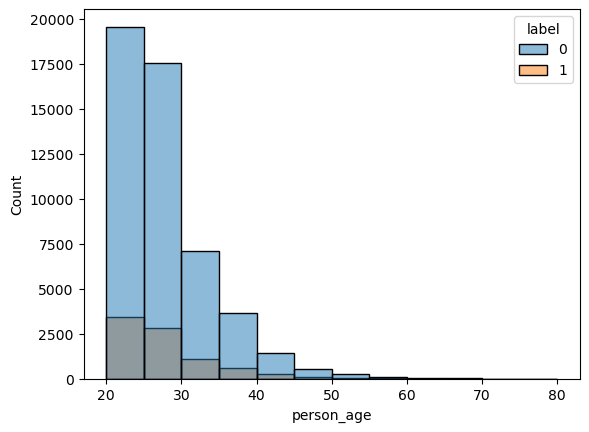

In [16]:
sns.histplot(prepro[prepro['person_age'] <= 80], x='person_age', hue='label', binwidth=5)

In [17]:
X_train['person_age_bin'] = np.where(X_train['person_age'] <= 30, 3,
                                     np.where(X_train['person_age'] <= 40, 2,
                                              np.where(X_train['person_age'] <= 70, 1, 0)))

<Axes: xlabel='person_income', ylabel='Count'>

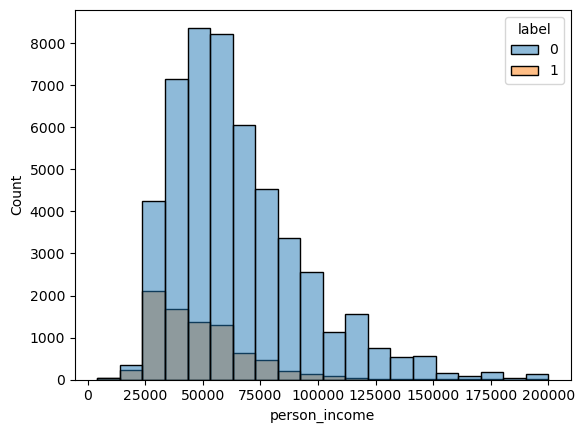

In [18]:
sns.histplot(prepro[prepro['person_income'] <= 200000], x='person_income', hue='label', binwidth=10000)

In [19]:
X_train['person_income_bin'] = np.where(X_train['person_income'] <= 50000, 3,
                                     np.where(X_train['person_income'] <= 75000, 2,
                                              np.where(X_train['person_income'] <= 125000, 1, 0)))

<Axes: xlabel='loan_amnt', ylabel='Count'>

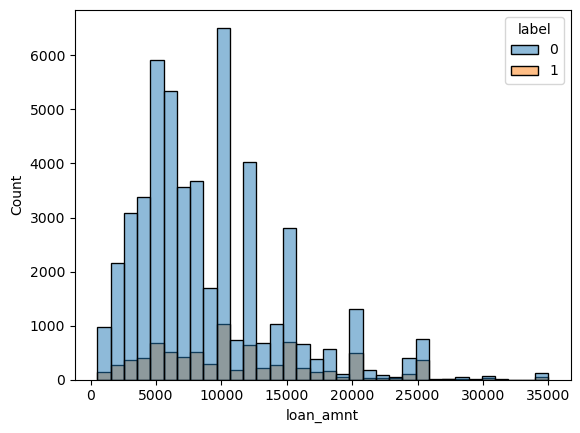

In [20]:
sns.histplot(prepro, x='loan_amnt', hue='label', binwidth=1000)

<Axes: xlabel='person_emp_length', ylabel='Count'>

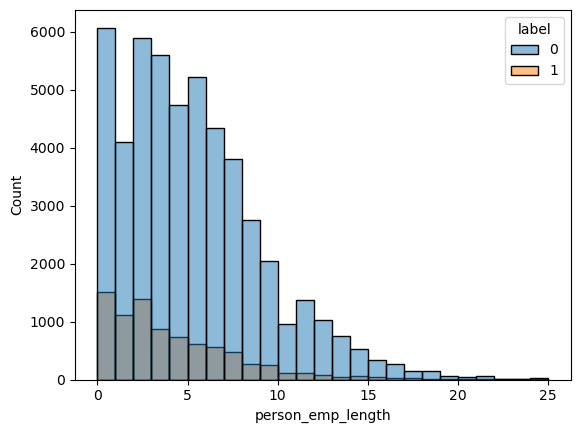

In [21]:
sns.histplot(prepro[prepro['person_emp_length'] <= 25], x='person_emp_length', hue='label', binwidth=1)

<Axes: xlabel='loan_grade', ylabel='Count'>

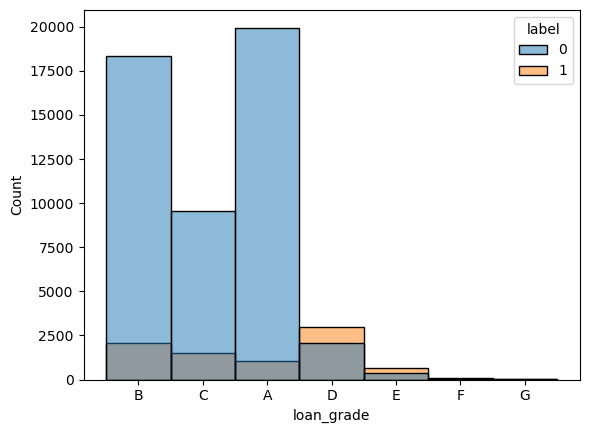

In [22]:
sns.histplot(prepro, x='loan_grade', hue='label', binwidth=1)

<Axes: xlabel='person_home_ownership', ylabel='Count'>

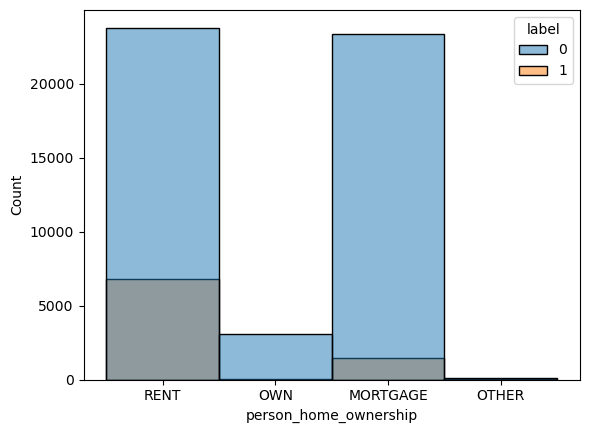

In [23]:
sns.histplot(prepro, x='person_home_ownership', hue='label', binwidth=1)

<Axes: xlabel='loan_percent_income', ylabel='Count'>

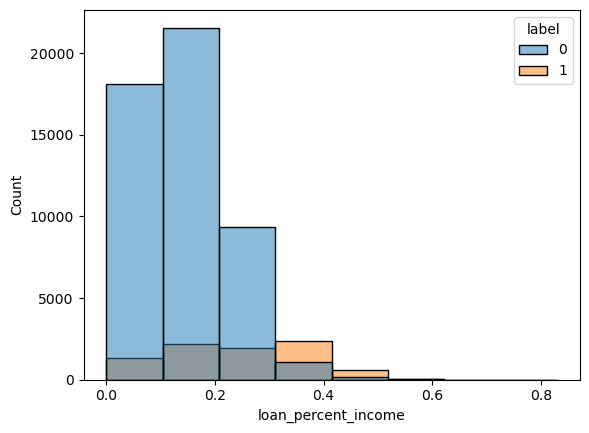

In [52]:
sns.histplot(prepro, x='loan_percent_income', hue='label', binwidth=0.1)

In [24]:
ohe = OneHotEncoder(sparse_output=False, min_frequency=5, handle_unknown='infrequent_if_exist')
X_train_ohe = ohe.fit_transform(X_train.drop(['person_age', 'person_age_bin', 'person_income', 'person_income_bin', 'person_emp_length', 'loan_amnt', 'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length', 'loan_grade', 'person_home_ownership', 'cb_person_default_on_file'], axis=1))
X_train_ohe = pd.DataFrame(X_train_ohe, columns=ohe.get_feature_names_out()).reset_index(drop=True)
X_train = X_train.drop(['loan_intent'], axis=1)

poly = PolynomialFeatures(degree=1)
X_train = poly.fit_transform(X_train)
X_train = pd.DataFrame(X_train, columns=poly.get_feature_names_out()).drop('1', axis=1)

X_train = pd.merge(X_train.reset_index(drop=True), X_train_ohe, left_index=True, right_index=True)

sm = SMOTE(sampling_strategy='auto', random_state=42)
X_train, y_train = sm.fit_resample(X_train, y_train)

In [25]:
y_train.value_counts()

loan_status
0    50295
1    50295
Name: count, dtype: int64

# Model

In [26]:
data = {
    "X_train": X_train,
    "y_train": y_train
}

datasets = ray.put(data)

In [27]:
def makeXGB(config):
    data = ray.get(datasets)
    X_train = data['X_train']
    y_train = data['y_train']
    
    model = xgb.XGBClassifier(n_estimators=config['n_estimators'],
                              max_depth=config['max_depth'],
                              max_leaves=config['max_leaves'],
                              learning_rate=config['learning_rate'],
                              gamma=config['gamma'],
                              min_child_weight=config['min_child_weight'],
                              max_delta_step=config['max_delta_step'],
                              subsample=config['subsample'],
                              colsample_bytree=config['colsample_bytree'],
                              colsample_bylevel=config['colsample_bylevel'],
                              colsample_bynode=config['colsample_bynode'],
                              enable_categorical=config['enable_categorical'],
                              max_cat_to_onehot=config['max_cat_to_onehot'],
                              max_cat_threshold=config['max_cat_threshold'],
                              eval_metric='auc',
                              random_state=47)
    
    kfold = StratifiedKFold(n_splits=config['splits'], shuffle=True, random_state=47)

    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring='roc_auc')

    ray.train.report(metrics={'auc': cv_results.mean()})

In [28]:
config={
    'n_estimators': tune.randint(500, 1500),
    'max_depth': tune.randint(20, 100),
    'max_leaves': tune.randint(0, 100),
    'learning_rate': tune.uniform(0.01, 0.5),
    'gamma': tune.randint(0, 5),
    'min_child_weight': tune.randint(1, 30),
    'max_delta_step': tune.randint(0, 30),
    'subsample': tune.uniform(0.8, 1.0),
    'colsample_bytree': tune.uniform(0.8, 1.0),
    'colsample_bylevel': tune.uniform(0.8, 1.0),
    'colsample_bynode': tune.uniform(0.8, 1.0),
    'enable_categorical': tune.choice([True, False]),
    'max_cat_to_onehot': tune.randint(100, 500),
    'max_cat_threshold': tune.randint(100, 500),
    'splits': tune.randint(3, 7)
}

In [29]:
print(f"Available resources: {ray.available_resources()}")

Available resources: {'accelerator_type:G': 1.0, 'node:172.25.175.114': 1.0, 'node:__internal_head__': 1.0, 'CPU': 24.0, 'memory': 18679067444.0, 'object_store_memory': 9339533721.0, 'GPU': 1.0}


In [30]:
reporter = CLIReporter(
    metric='auc',
    mode='max'
)

hyperband = HyperBandScheduler(
    metric='auc',
    mode='max',
    max_t=20
)


tuner = Tuner(
    tune.with_resources(makeXGB, resources={"gpu": 1}),
    param_space=config,
    tune_config=tune.TuneConfig(num_samples=100, scheduler=hyperband),
    run_config=air.RunConfig(progress_reporter=reporter)
)

analysis = tuner.fit()

2024-10-30 09:43:49,138	INFO tune.py:616 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949


2024-10-30 09:43:49,226	INFO hyperband.py:183 -- Bracket too small - Retrying...
2024-10-30 09:43:49,267	INFO hyperband.py:183 -- Bracket too small - Retrying...
2024-10-30 09:43:49,305	INFO hyperband.py:183 -- Bracket too small - Retrying...
2024-10-30 09:43:49,344	INFO hyperband.py:183 -- Bracket too small - Retrying...


== Status ==
Current time: 2024-10-30 09:43:49 (running for 00:00:00.54)
Using HyperBand: num_stopped=0 total_brackets=19
Round #0:
  Bracket(Max Size (n)=4, Milestone (r)=20, completed=0.0%): {PENDING: 4} 
  Bracket(Max Size (n)=6, Milestone (r)=6, completed=0.0%): {PENDING: 6} 
  Bracket(Max Size (n)=12, Milestone (r)=2, completed=0.0%): {PENDING: 12} 
Round #1:
  Bracket(Max Size (n)=4, Milestone (r)=20, completed=0.0%): {PENDING: 4} 
  Bracket(Max Size (n)=6, Milestone (r)=6, completed=0.0%): {PENDING: 6} 
  Bracket(Max Size (n)=12, Milestone (r)=2, completed=0.0%): {PENDING: 12} 
Round #2:
  Bracket(Max Size (n)=4, Milestone (r)=20, completed=0.0%): {PENDING: 4} 
  Bracket(Max Size (n)=6, Milestone (r)=6, completed=0.0%): {PENDING: 6} 
  Bracket(Max Size (n)=12, Milestone (r)=2, completed=0.0%): {PENDING: 12} 
Round #3:
  Bracket(Max Size (n)=4, Milestone (r)=20, completed=0.0%): {PENDING: 4} 
  Bracket(Max Size (n)=6, Milestone (r)=6, completed=0.0%): {PENDING: 6} 
  Bracket(Max 

2024-10-30 10:04:20,821	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to '/home/nicomore/ray_results/makeXGB_2024-10-30_09-43-49' in 0.0082s.
2024-10-30 10:04:20,835	INFO tune.py:1041 -- Total run time: 1231.70 seconds (1231.62 seconds for the tuning loop).


== Status ==
Current time: 2024-10-30 10:04:20 (running for 00:20:31.58)
Using HyperBand: num_stopped=0 total_brackets=19
Round #0:
  Bracket(Max Size (n)=4, Milestone (r)=20, completed=100.0%): {TERMINATED: 4} 
  Bracket(Max Size (n)=2, Milestone (r)=18, completed=100.0%): {TERMINATED: 6} 
  Bracket(Max Size (n)=4, Milestone (r)=6, completed=14.3%): {TERMINATED: 12} 
Round #1:
  Bracket(Max Size (n)=4, Milestone (r)=20, completed=100.0%): {TERMINATED: 4} 
  Bracket(Max Size (n)=2, Milestone (r)=18, completed=100.0%): {TERMINATED: 6} 
  Bracket(Max Size (n)=4, Milestone (r)=6, completed=14.3%): {TERMINATED: 12} 
Round #2:
  Bracket(Max Size (n)=4, Milestone (r)=20, completed=100.0%): {TERMINATED: 4} 
  Bracket(Max Size (n)=2, Milestone (r)=18, completed=100.0%): {TERMINATED: 6} 
  Bracket(Max Size (n)=4, Milestone (r)=6, completed=14.3%): {TERMINATED: 12} 
Round #3:
  Bracket(Max Size (n)=4, Milestone (r)=20, completed=100.0%): {TERMINATED: 4} 
  Bracket(Max Size (n)=2, Milestone (r)=1

In [31]:
best = analysis.get_best_result(metric='auc', mode='max')
best = best.config
best['early_stopping_rounds'] = 5
best['eval_metric'] = 'auc'
best['random_state'] = 47

print(best['splits'])

del best['splits']

best

5


{'n_estimators': 782,
 'max_depth': 55,
 'max_leaves': 14,
 'learning_rate': 0.1067232992549191,
 'gamma': 0,
 'min_child_weight': 1,
 'max_delta_step': 18,
 'subsample': 0.8040603419882825,
 'colsample_bytree': 0.924239742565552,
 'colsample_bylevel': 0.9838431577801038,
 'colsample_bynode': 0.8275156691644627,
 'enable_categorical': False,
 'max_cat_to_onehot': 127,
 'max_cat_threshold': 132,
 'early_stopping_rounds': 5,
 'eval_metric': 'auc',
 'random_state': 47}

In [32]:
endmodel = xgb.XGBClassifier(**best)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=47)
endmodel.fit(X_train, y_train, eval_set=[(X_val, y_val)])

[0]	validation_0-auc:0.91628
[1]	validation_0-auc:0.94427
[2]	validation_0-auc:0.95242
[3]	validation_0-auc:0.95266
[4]	validation_0-auc:0.95748
[5]	validation_0-auc:0.95930
[6]	validation_0-auc:0.96217
[7]	validation_0-auc:0.96440
[8]	validation_0-auc:0.96598
[9]	validation_0-auc:0.96639
[10]	validation_0-auc:0.96872
[11]	validation_0-auc:0.96985
[12]	validation_0-auc:0.97156
[13]	validation_0-auc:0.97227
[14]	validation_0-auc:0.97235
[15]	validation_0-auc:0.97257
[16]	validation_0-auc:0.97288
[17]	validation_0-auc:0.97343
[18]	validation_0-auc:0.97356
[19]	validation_0-auc:0.97443
[20]	validation_0-auc:0.97502
[21]	validation_0-auc:0.97522
[22]	validation_0-auc:0.97614
[23]	validation_0-auc:0.97660
[24]	validation_0-auc:0.97685
[25]	validation_0-auc:0.97716
[26]	validation_0-auc:0.97815
[27]	validation_0-auc:0.97886
[28]	validation_0-auc:0.97941
[29]	validation_0-auc:0.97974
[30]	validation_0-auc:0.98024
[31]	validation_0-auc:0.98093
[32]	validation_0-auc:0.98133
[33]	validation_0-au

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=0.9838431577801038,
              colsample_bynode=0.8275156691644627,
              colsample_bytree=0.924239742565552, device=None,
              early_stopping_rounds=5, enable_categorical=False,
              eval_metric='auc', feature_types=None, gamma=0, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1067232992549191, max_bin=None,
              max_cat_threshold=132, max_cat_to_onehot=127, max_delta_step=18,
              max_depth=55, max_leaves=14, min_child_weight=1, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=782,
              n_jobs=None, num_parallel_tree=None, random_state=47, ...)

In [33]:
pd.DataFrame(endmodel.feature_importances_, endmodel.feature_names_in_).sort_values(by=0, ascending=False)

,0
loan_grade,0.203200
person_home_ownership,0.161534
loan_percent_income,0.111062
cb_person_default_on_file,0.091144
loan_intent_EDUCATION,0.082055
loan_intent_DEBTCONSOLIDATION,0.059849
loan_intent_VENTURE,0.057167
loan_intent_PERSONAL,0.050018
loan_intent_HOMEIMPROVEMENT,0.047304
loan_intent_MEDICAL,0.039999


In [34]:
"""
test_ohe = ohe.transform(test.drop(['person_age', 'person_income', 'person_emp_length', 'loan_amnt', 'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length', 'loan_grade', 'person_home_ownership', 'cb_person_default_on_file'], axis=1))
test_ohe = pd.DataFrame(test_ohe, columns=ohe.get_feature_names_out()).reset_index(drop=True)
test = test.drop(['loan_intent'], axis=1)
test = pd.DataFrame(poly.transform(test), columns=poly.get_feature_names_out())
test = pd.merge(test.drop('1', axis=1).reset_index(drop=True), test_ohe, left_index=True, right_index=True)
""" 

"\ntest_ohe = ohe.transform(test.drop(['person_age', 'person_income', 'person_emp_length', 'loan_amnt', 'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length', 'loan_grade', 'person_home_ownership', 'cb_person_default_on_file'], axis=1))\ntest_ohe = pd.DataFrame(test_ohe, columns=ohe.get_feature_names_out()).reset_index(drop=True)\ntest = test.drop(['loan_intent'], axis=1)\ntest = pd.DataFrame(poly.transform(test), columns=poly.get_feature_names_out())\ntest = pd.merge(test.drop('1', axis=1).reset_index(drop=True), test_ohe, left_index=True, right_index=True)\n"

In [35]:
test = pd.read_csv('test.csv').drop('id', axis=1)
test

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,23,69000,RENT,3.0,HOMEIMPROVEMENT,F,25000,15.76,0.36,N,2
1,26,96000,MORTGAGE,6.0,PERSONAL,C,10000,12.68,0.10,Y,4
2,26,30000,RENT,5.0,VENTURE,E,4000,17.19,0.13,Y,2
3,33,50000,RENT,4.0,DEBTCONSOLIDATION,A,7000,8.90,0.14,N,7
4,26,102000,MORTGAGE,8.0,HOMEIMPROVEMENT,D,15000,16.32,0.15,Y,4
...,...,...,...,...,...,...,...,...,...,...,...
39093,22,31200,MORTGAGE,2.0,DEBTCONSOLIDATION,B,3000,10.37,0.10,N,4
39094,22,48000,MORTGAGE,6.0,EDUCATION,A,7000,6.03,0.15,N,3
39095,51,60000,MORTGAGE,0.0,PERSONAL,A,15000,7.51,0.25,N,25
39096,22,36000,MORTGAGE,4.0,PERSONAL,D,14000,15.62,0.39,Y,4


In [36]:
test['person_home_ownership'] = np.where(test['person_home_ownership'] == 'OWN', 0, 
                                            np.where(test['person_home_ownership'] == 'MORTGAGE', 1,
                                                     np.where(test['person_home_ownership'] == 'OTHER', 3, 4)))

In [37]:
test['loan_grade'] = np.where(test['loan_grade'] == 'A', 0, 
                                 np.where(test['loan_grade'] == 'B', 1,
                                          np.where(test['loan_grade'] == 'C', 2, 
                                                   np.where(test['loan_grade'] == 'G', 4, 3))))

In [38]:
test['cb_person_default_on_file'] = np.where(test['cb_person_default_on_file'] == 'Y', 1, 0)

In [39]:
test['person_age_bin'] = np.where(test['person_age'] <= 30, 3,
                                     np.where(test['person_age'] <= 40, 2,
                                              np.where(test['person_age'] <= 70, 1, 0)))

In [40]:
test['person_income_bin'] = np.where(test['person_income'] <= 50000, 3,
                                     np.where(test['person_income'] <= 75000, 2,
                                              np.where(test['person_income'] <= 125000, 1, 0)))

In [41]:
test_ohe = ohe.transform(test.drop(['person_age', 'person_age_bin', 'person_income', 'person_income_bin', 'person_emp_length', 'loan_amnt', 'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length', 'loan_grade', 'person_home_ownership', 'cb_person_default_on_file'], axis=1))
test_ohe = pd.DataFrame(test_ohe, columns=ohe.get_feature_names_out()).reset_index(drop=True)
test = test.drop(['loan_intent'], axis=1)
test = pd.DataFrame(poly.transform(test), columns=poly.get_feature_names_out())
test = pd.merge(test.drop('1', axis=1).reset_index(drop=True), test_ohe, left_index=True, right_index=True)
# test = pd.merge(test.reset_index(drop=True), test_ohe, left_index=True, right_index=True)

In [42]:
pred = endmodel.predict_proba(test)

In [43]:
pred[:,1]

array([0.9917142 , 0.02036632, 0.5399122 , ..., 0.01156049, 0.1985409 ,
       0.95396554], dtype=float32)

In [44]:
testdata = test

In [45]:
test = pd.DataFrame(pd.read_csv('test.csv')['id'])

In [46]:
test['loan_status'] = pred[:,1]

In [47]:
test

,id,loan_status
0,58645,0.991714
1,58646,0.020366
2,58647,0.539912
3,58648,0.012920
4,58649,0.057896
...,...,...
39093,97738,0.051765
39094,97739,0.005721
39095,97740,0.011560
39096,97741,0.198541


In [48]:
test.to_csv('submission.csv', index=False)

In [49]:
testdata['loan_status'] = pred[:,1]
testdata[testdata.index.isin(test[(test['loan_status'] >= 0.4) & (test['loan_status'] <= 0.6)].index)]

,person_age,person_income,person_home_ownership,person_emp_length,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,person_age_bin,person_income_bin,loan_intent_DEBTCONSOLIDATION,loan_intent_EDUCATION,loan_intent_HOMEIMPROVEMENT,loan_intent_MEDICAL,loan_intent_PERSONAL,loan_intent_VENTURE,loan_status
2,26.0,30000.0,4.0,5.0,3.0,4000.0,17.19,0.13,1.0,2.0,3.0,3.0,0.0,0.0,0.0,0.0,0.0,1.0,0.539912
42,25.0,83000.0,4.0,5.0,3.0,25000.0,12.92,0.29,1.0,2.0,3.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.563545
94,26.0,34995.0,4.0,4.0,1.0,10000.0,11.26,0.29,0.0,2.0,3.0,3.0,0.0,1.0,0.0,0.0,0.0,0.0,0.409556
159,22.0,51000.0,4.0,3.0,3.0,15000.0,15.62,0.29,1.0,4.0,3.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.559964
210,37.0,54996.0,4.0,0.0,2.0,15000.0,15.96,0.27,0.0,14.0,2.0,2.0,0.0,0.0,0.0,0.0,1.0,0.0,0.473952
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38897,28.0,37000.0,4.0,0.0,1.0,8000.0,12.21,0.19,0.0,8.0,3.0,3.0,0.0,0.0,1.0,0.0,0.0,0.0,0.588690
38927,25.0,25920.0,4.0,3.0,3.0,7000.0,15.58,0.28,0.0,4.0,3.0,3.0,0.0,1.0,0.0,0.0,0.0,0.0,0.455834
38942,22.0,12000.0,0.0,0.0,3.0,1600.0,18.79,0.13,0.0,2.0,3.0,3.0,0.0,1.0,0.0,0.0,0.0,0.0,0.510357
38943,26.0,34800.0,4.0,6.0,1.0,10000.0,11.11,0.29,0.0,4.0,3.0,3.0,0.0,0.0,0.0,0.0,1.0,0.0,0.547322
